In [1]:
%matplotlib inline

import cosima_cookbook as cc
import matplotlib.pyplot as plt
import numpy as np
import cmocean as cm

import matplotlib
from matplotlib import rc
rc('font',**{'family':'sans-serif'})
rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = [
    r'\usepackage{amsmath}',
    r'\usepackage{amsfonts}',
    r'\usepackage{amssymb}']
rc('text', usetex=False)

import xarray as xr
import xgcm

import cartopy.crs as ccrs
import cartopy.feature as cft
land_50m = cft.NaturalEarthFeature('physical', 'land', '50m',
                                   edgecolor='black', facecolor='papayawhip', linewidth=0.5)

import matplotlib.path as mpath




In [23]:
rc('font',**{'family':'serif'})


In [2]:
import matplotlib.ticker as mticker

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER


In [3]:
# set up a larger cluster
from dask.distributed import Client,Scheduler
from dask_jobqueue import SLURMCluster





In [4]:
# either way, run this
client = Client()



In [5]:
print(client)

<Client: 'tcp://127.0.0.1:43431' processes=7 threads=14, memory=64.00 GiB>


## Input parameters

In [6]:
# these are the values used by MOM5

Ω = 7.292e-5     # Earth's rotation rate in radians/s
Rearth = 6371.e3 # Earth's radius in m


# 1/20° Pan-Antarctic

In [7]:
# load simulation data and rename some axes
ds_panant = xr.open_mfdataset('/g/data/ik11/outputs/mom6-panan/panant-v2/restart095/MOM.res*.nc', chunks='auto')
ds_panant = ds_panant.rename({'latq':'yq'}).rename({'lath':'yh'}).rename({'lonq':'xq'}).rename({'lonh':'xh'})

In [8]:
# load grid data
ds_grid = xr.open_mfdataset('/g/data/ik11/outputs/mom6-panan/panant-v2/output000/19910101.ocean_static.nc', chunks='auto')

In [9]:
# merge the two 
ds_panant = xr.merge([ds_panant, ds_grid])

In [10]:
# xgcm doesn't work well when fields are defined on the 'outer' position in axes, so drop one row and one column from these fields
# to shift them to 'left'
ds_panant = ds_panant.drop_sel(xq=ds_panant.xq[-1])
ds_panant = ds_panant.drop_sel(yq=ds_panant.yq[-1])

In [11]:
# define grid metrics for automagic differentiation
metrics = {
    ('X',): ['dxCu', 'dxCv'],
    ('Y',): ['dyCu', 'dyCv'],
            }

In [12]:
grid = xgcm.Grid(ds_panant, coords={'X':{'center':'xh', 'left':'xq'},
                             'Y':{'center':'yh', 'left':'yq',},
                             'Z':{'center':'Layer', 'outer':'Interface'}}, periodic = ['X'],
                metrics=metrics)

In [13]:
grid

<xgcm.Grid>
X Axis (periodic, boundary=None):
  * center   xh --> left
  * left     xq --> center
Y Axis (not periodic, boundary=None):
  * center   yh --> left
  * left     yq --> center
Z Axis (not periodic, boundary=None):
  * center   Layer --> outer
  * outer    Interface --> center

In [14]:
# calculate relative vorticity

zeta = grid.derivative(ds_panant.v, 'X') - grid.derivative(ds_panant.u, 'Y')

# assign name and units
zeta = zeta.rename('Relative Vorticity')
zeta.attrs['long_name'] = 'Relative Vorticity, ∂v/∂x-∂u/∂y'
zeta.attrs['units'] = 's-1'

In [15]:
# calculate Coriolis
# (there is a Coriolis field in the grid info, but I found it easier to calculate like this and broadcast

f_panant = 2 * Ω * np.sin(np.deg2rad(ds_panant['yq'])) # convert lat in radians
f_panant = f_panant.rename('Coriolis')
f_panant.attrs['long_name'] = 'Coriolis parameter'
f_panant.attrs['units'] = 's-1'

# f_panant = grid.interp(grid.interp(f, 'X'), 'Y', boundary='extend')



In [16]:
%%time
zeta.load()
Ro_panant = zeta/f_panant

CPU times: user 33.9 s, sys: 52.5 s, total: 1min 26s
Wall time: 3min 36s


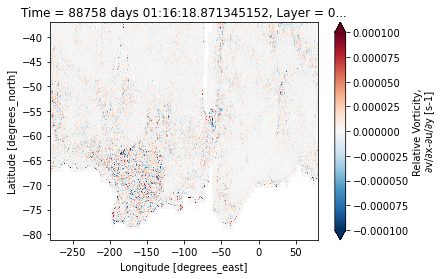

In [17]:
zeta.sel(Layer=0, method='nearest').plot(vmin=-1e-4, vmax=1e-4, cmap='RdBu_r')

CPU times: user 30.4 s, sys: 1min 44s, total: 2min 14s
Wall time: 2min


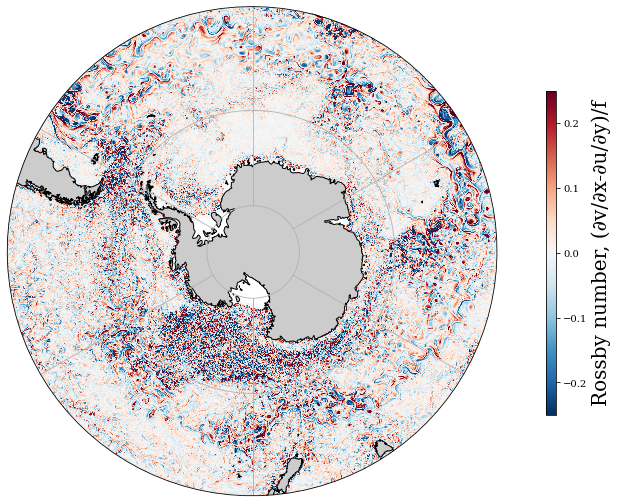

In [24]:
%%time

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(1, 1, 1, projection=projection)

ax.set_extent([-280, 80, -80, -40], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')


# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

p1 = Ro_panant.sel(Layer=0, method='nearest').squeeze().plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                                                         add_colorbar=False, vmin=-0.25, vmax=0.25, cmap='RdBu_r')
ax.set_title('')

gl = ax.gridlines(ylim=(-80,80), ylocs=[-80, -70, -60, -50, -40, -30]) #y_inline=True, 
# crs=ccrs.PlateCarree(), draw_labels=True,
#                   linewidth=2, color='black', alpha=0.5, linestyle='--')
# gl.xlabels_top = False
# gl.ylabels_left = False
# gl.xlines = False
# gl.xlocator = mticker.FixedLocator([-180, -45, 0, 45, 180])
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
# gl.xlabel_style = {'size': 15, 'color': 'gray'}
# gl.xlabel_style = {'color': 'red', 'weight': 'bold'}



ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('Rossby number, (∂v/∂x-∂u/∂y)/f', fontsize=20);

fig.savefig('/g/data/jk72/ed7737/RoG plots/Panantarctic-Rossby_number.png', dpi=300, bbox_inches='tight')

CPU times: user 28.1 s, sys: 1min 21s, total: 1min 49s
Wall time: 1min 38s


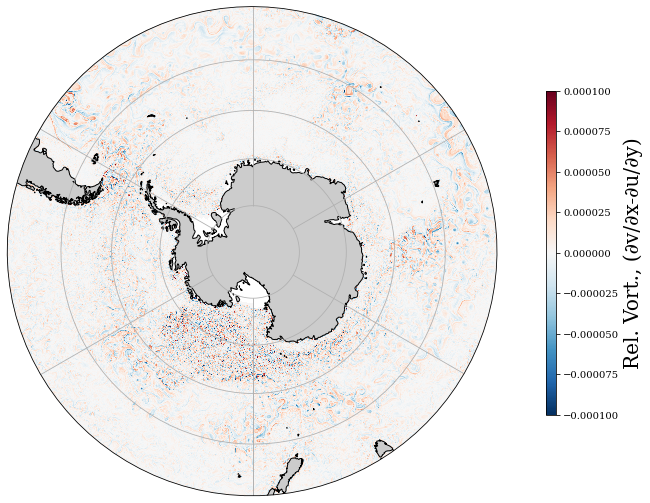

In [25]:
%%time

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(1, 1, 1, projection=projection)

ax.set_extent([-280, 80, -80, -40], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')


# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)
gl = ax.gridlines(ylim=(-80,80), ylocs=[-80, -70, -60, -50, -40, -30], draw_labels=True) #y_inline=True, 

p1 = zeta.sel(Layer=0, method='nearest').squeeze().plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                                                         add_colorbar=False, vmin=-1e-4, vmax=1e-4, cmap='RdBu_r')
ax.set_title('')

ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical')
cb.ax.set_ylabel('Rel. Vort., (∂v/∂x-∂u/∂y)', fontsize=20);

fig.savefig('/g/data/jk72/ed7737/RoG plots/Panantarctic-zeta.png', dpi=200, bbox_inches='tight')

In [26]:
import cartopy
import cartopy.mpl.geoaxes
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import matplotlib.patches as mpatches

# function to make boundary path
# make a path around boundary to create a sector map, then cut it out

def make_boundary_path(lons, lats):
    boundary_path = np.array([lons[-1, :], lats[-1, :]])
    boundary_path = np.append(boundary_path, np.array([lons[::-1, -1], lats[::-1, -1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[1, ::-1], lats[1, ::-1]]), axis=1)
    boundary_path = np.append(boundary_path, np.array([lons[:, 1], lats[:, 1]]), axis=1)
    boundary_path = mpath.Path(np.swapaxes(boundary_path, 0, 1))
    return boundary_path

CPU times: user 2min, sys: 5min 17s, total: 7min 18s
Wall time: 7min 4s


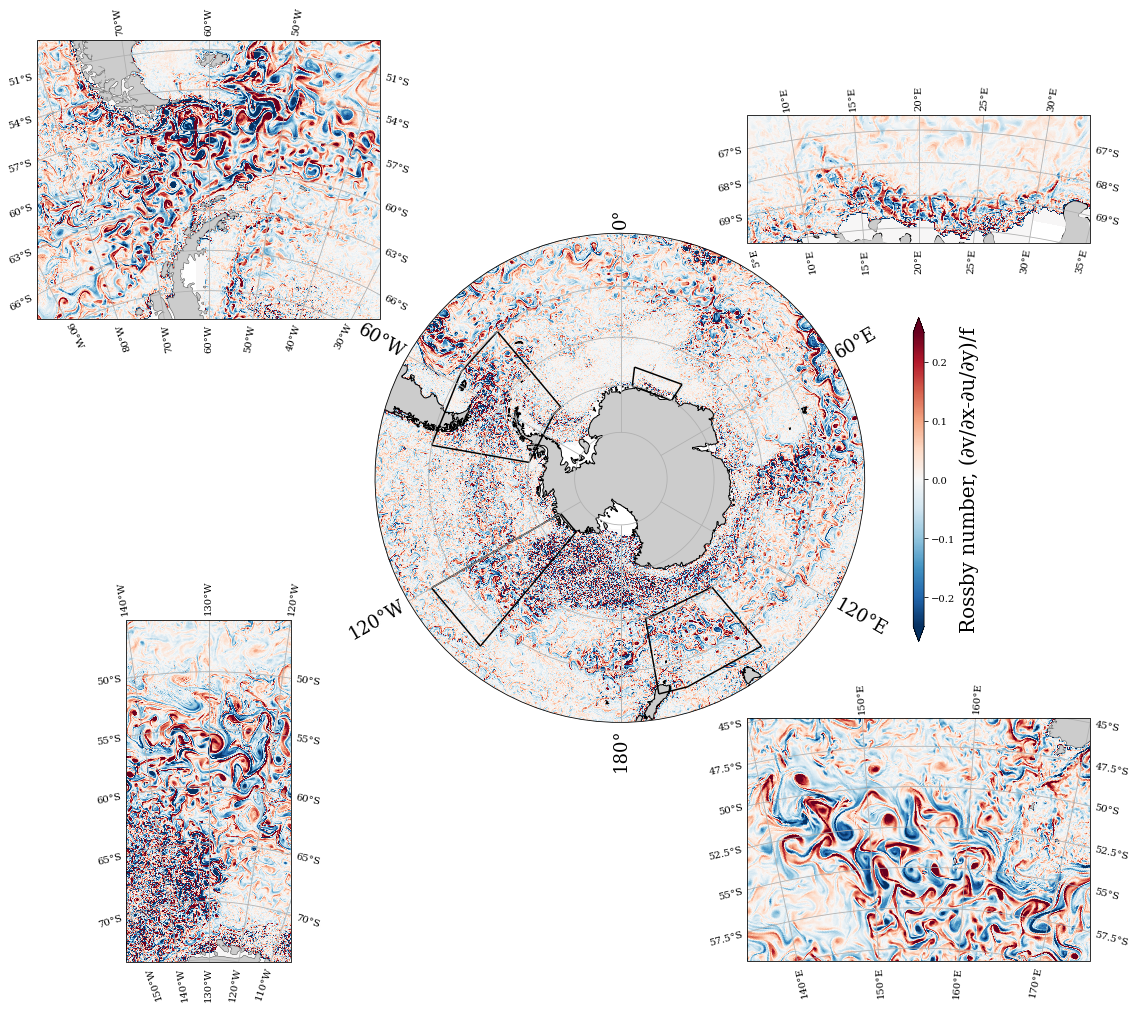

In [34]:
%%time

projection=ccrs.SouthPolarStereo()

fig = plt.figure(figsize=(10, 9))
ax = plt.subplot(1, 1, 1, projection=projection)

ax.set_extent([-280, 80, -80, -40], crs=ccrs.PlateCarree())
ax.add_feature(land_50m, color=[0.8, 0.8, 0.8])
ax.coastlines(resolution='50m')


# Compute a circle in axes coordinates, which we can use as a boundary
# for the map. We can pan/zoom as much as we like - the boundary will be
# permanently circular.
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpath.Path(verts * radius + center)
ax.set_boundary(circle, transform=ax.transAxes)

gl = ax.gridlines(ylim=(-80,80), ylocs=[-80, -70, -60, -50, -40, -30], draw_labels='x', y_inline=False, xlabel_style={'size':18})


p1 = Ro_panant.sel(Layer=0, method='nearest').squeeze().plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(),
                                                         add_colorbar=False, vmin=-0.25, vmax=0.25, cmap='RdBu_r')

ax.set_title('')

ax_cb = plt.axes([0.92, 0.25, 0.015, 0.5])
cb = plt.colorbar(p1, cax=ax_cb, orientation='vertical', extend='both')
cb.ax.set_ylabel('Rossby number, (∂v/∂x-∂u/∂y)/f', fontsize=20);



### Insert axes

#############################
### first insert - top right
delta_lon = 13
midlon = 20
maxlon = midlon + delta_lon
minlon = midlon - delta_lon
minlat = -70
delta_lat = 4
maxlat = minlat + delta_lat
midlat = (minlat + maxlat)/2

lons = ds_panant.geolon_c.sel(xq=slice(minlon, maxlon)).sel(yq=slice(minlat, maxlat))
lats = ds_panant.geolat_c.sel(xq=slice(minlon, maxlon)).sel(yq=slice(minlat, maxlat))


axins_0 = inset_axes(ax, width="70%", height="70%", loc="lower left", 
                   bbox_to_anchor=(0.75,0.75,1,1),
                   bbox_transform=ax.transAxes,
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cartopy.crs.Stereographic(central_longitude=midlon, central_latitude=midlat)))

axins_0.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

p_ins_0 = Ro_panant.sel(Layer=0, method='nearest').squeeze().plot.pcolormesh(ax=axins_0, transform=ccrs.PlateCarree(),
                                                         add_colorbar=False, vmin=-0.25, vmax=0.25, cmap='RdBu_r')

axins_0.set_title('')

# to make it a sector map
# boundary_path = make_boundary_path(lons, lats)
# axins_0.set_boundary(boundary_path, transform=ccrs.PlateCarree())

axins_0.add_feature(cartopy.feature.COASTLINE)
axins_0.add_feature(land_50m, color=[0.8, 0.8, 0.8])
axins_0.gridlines(draw_labels=True, y_inline=False)

# these lines are a bit jagged - could be improved.
ax.hlines([minlat, maxlat], minlon, maxlon, colors='k', transform=ccrs.PlateCarree())
ax.vlines([minlon, maxlon], minlat, maxlat, colors='k', transform=ccrs.PlateCarree())



##########################
### second insert - bottom right

delta_lon = 15
midlon = 155
maxlon = midlon + delta_lon
minlon = midlon - delta_lon
minlat = -60
delta_lat = 15
maxlat = minlat + delta_lat
midlat = (minlat + maxlat)/2

lons = ds_panant.geolon_c.sel(xq=slice(minlon, maxlon)).sel(yq=slice(minlat, maxlat))
lats = ds_panant.geolat_c.sel(xq=slice(minlon, maxlon)).sel(yq=slice(minlat, maxlat))


axins_1 = inset_axes(ax, width="70%", height="70%", loc="lower left", 
                   bbox_to_anchor=(0.75,-0.6,1,1),
                   bbox_transform=ax.transAxes,
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cartopy.crs.Stereographic(central_longitude=midlon, central_latitude=midlat)))

axins_1.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


p_ins_1 = Ro_panant.sel(Layer=0, method='nearest').squeeze().plot.pcolormesh(ax=axins_1, transform=ccrs.PlateCarree(),
                                                         add_colorbar=False, vmin=-0.25, vmax=0.25, cmap='RdBu_r')

axins_1.set_title('')

# to make it a sector map
# boundary_path = make_boundary_path(lons, lats)
# axins_1.set_boundary(boundary_path, transform=ccrs.PlateCarree())

# these lines are a bit jagged - could be improved.
ax.hlines([minlat, maxlat], minlon, maxlon, colors='k', transform=ccrs.PlateCarree())
ax.vlines([minlon, maxlon], minlat, maxlat, colors='k', transform=ccrs.PlateCarree())


axins_1.add_feature(cartopy.feature.COASTLINE)
axins_1.add_feature(land_50m, color=[0.8, 0.8, 0.8])
axins_1.gridlines(draw_labels=True, y_inline=False)





##########################
### third insert - bottom left

delta_lon = 10
midlon = 230
maxlon = midlon + delta_lon
minlon = midlon - delta_lon
minlat = -75
delta_lat = 30
maxlat = minlat + delta_lat
midlat = (minlat + maxlat)/2


lons = ds_panant.geolon_c.sel(xq=slice(minlon, maxlon)).sel(yq=slice(minlat, maxlat))
lats = ds_panant.geolat_c.sel(xq=slice(minlon, maxlon)).sel(yq=slice(minlat, maxlat))

# ax.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

axins_2 = inset_axes(ax, width="70%", height="70%", loc="lower left", 
                   bbox_to_anchor=(-0.7,-0.5,1,1),
                   bbox_transform=ax.transAxes,
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cartopy.crs.Stereographic(central_longitude=midlon, central_latitude=midlat)))

axins_2.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())


p_ins_2 = Ro_panant.sel(Layer=0, method='nearest').squeeze().plot.pcolormesh(ax=axins_2, transform=ccrs.PlateCarree(),
                                                         add_colorbar=False, vmin=-0.25, vmax=0.25, cmap='RdBu_r')

axins_2.set_title('')

# to make it a sector map
# boundary_path = make_boundary_path(lons, lats)
# axins_2.set_boundary(boundary_path, transform=ccrs.PlateCarree())

# these lines are a bit jagged - could be improved.
ax.hlines([minlat, maxlat], minlon, maxlon, colors='k', transform=ccrs.PlateCarree())
ax.vlines([minlon, maxlon], minlat, maxlat, colors='k', transform=ccrs.PlateCarree())


axins_2.add_feature(cartopy.feature.COASTLINE)
axins_2.add_feature(land_50m, color=[0.8, 0.8, 0.8])
axins_2.gridlines(draw_labels=True, y_inline=False)



#############################
### fourth insert
delta_lon = 20
midlon = -60
maxlon = midlon + delta_lon
minlon = midlon - delta_lon
minlat = -70
delta_lat = 20
maxlat = minlat + delta_lat
midlat = (minlat + maxlat)/2

lons = ds_panant.geolon_c.sel(xq=slice(minlon, maxlon)).sel(yq=slice(minlat, maxlat))
lats = ds_panant.geolat_c.sel(xq=slice(minlon, maxlon)).sel(yq=slice(minlat, maxlat))


axins_3 = inset_axes(ax, width="70%", height="70%", loc="lower left", 
                   bbox_to_anchor=(-0.7,0.75,1,1),
                   bbox_transform=ax.transAxes,
                   axes_class=cartopy.mpl.geoaxes.GeoAxes, 
                   axes_kwargs=dict(map_projection=cartopy.crs.Stereographic(central_longitude=midlon, central_latitude=midlat)))

axins_3.set_extent([minlon, maxlon, minlat, maxlat], crs=ccrs.PlateCarree())

p_ins_3 = Ro_panant.sel(Layer=0, method='nearest').squeeze().plot.pcolormesh(ax=axins_3, transform=ccrs.PlateCarree(),
                                                         add_colorbar=False, vmin=-0.25, vmax=0.25, cmap='RdBu_r')

axins_3.set_title('')

# to make it a sector map
# boundary_path = make_boundary_path(lons, lats)
# axins_0.set_boundary(boundary_path, transform=ccrs.PlateCarree())

axins_3.add_feature(cartopy.feature.COASTLINE)
axins_3.add_feature(land_50m, color=[0.8, 0.8, 0.8])
axins_3.gridlines(draw_labels=True, y_inline=False)


# these lines are a bit jagged - could be improved.
ax.hlines([minlat, maxlat], minlon, maxlon, colors='k', transform=ccrs.PlateCarree())
ax.vlines([minlon, maxlon], minlat, maxlat, colors='k', transform=ccrs.PlateCarree())




fig.savefig('/g/data/jk72/ed7737/RoG plots/Panantarctic-Rossby_number_with_insets.png', dpi=400, bbox_inches='tight')
